#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import TimeSeriesSplit

In [2]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates = [0], index_col = [0])

In [3]:
print('Количество пропусков:')
print()
print(df.isnull().sum())
print()
print()
print('Размер датафрейма:', df.shape[0])
print()
print()
print('Информация:')
print()
print(df.info())

Количество пропусков:

num_orders    0
dtype: int64


Размер датафрейма: 26496


Информация:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB
None


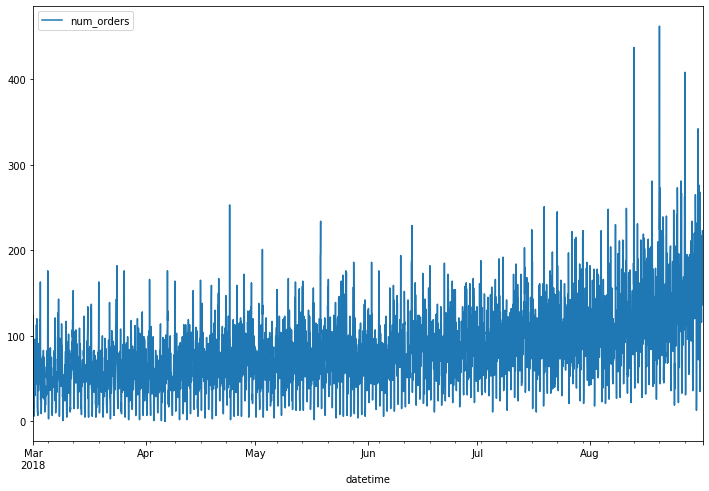

In [4]:
data = df.copy()

df.sort_index(inplace=True)
df = df.resample('1H').sum()

df.plot(figsize=(12, 8))

In [5]:
df.index.is_monotonic

True

## Анализ

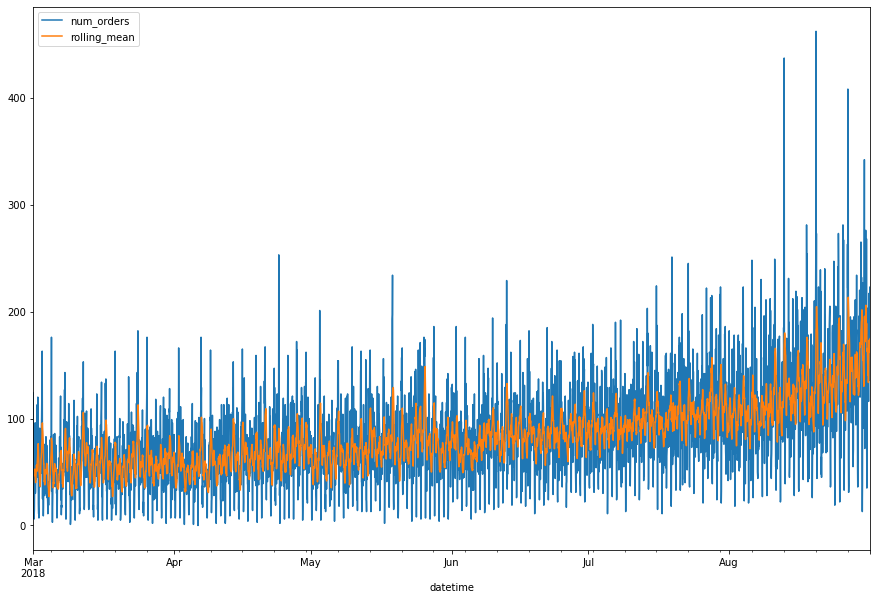

In [6]:
df['rolling_mean'] = df.rolling(10).mean()
df.plot(figsize = (15, 10))

In [7]:
df_month = data.copy()

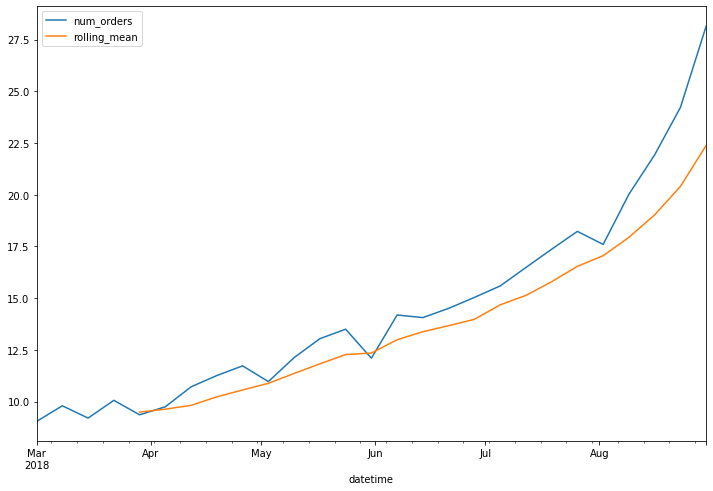

In [8]:
df_month = df_month.resample('7D').mean()

df_month['rolling_mean'] = df_month.rolling(5).mean()

df_month.plot(figsize=(12, 8))

Видим, что количество заказов из месяца в месяц растет

In [9]:
df_week = data.copy()

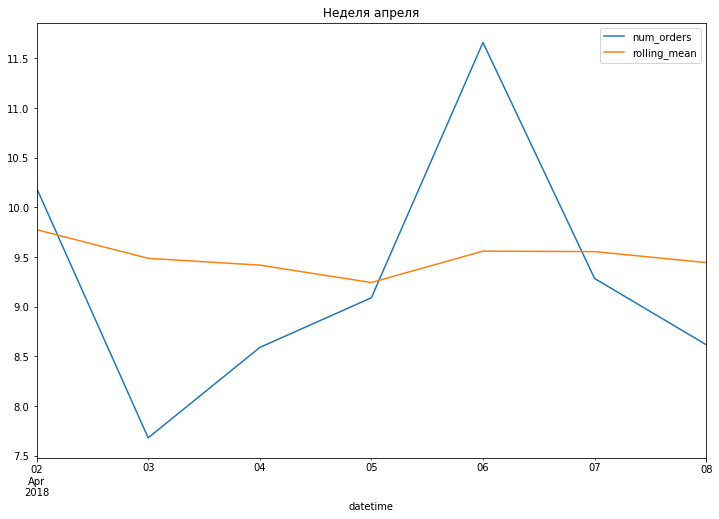

Text(0.5, 1.0, 'Неделя августа')

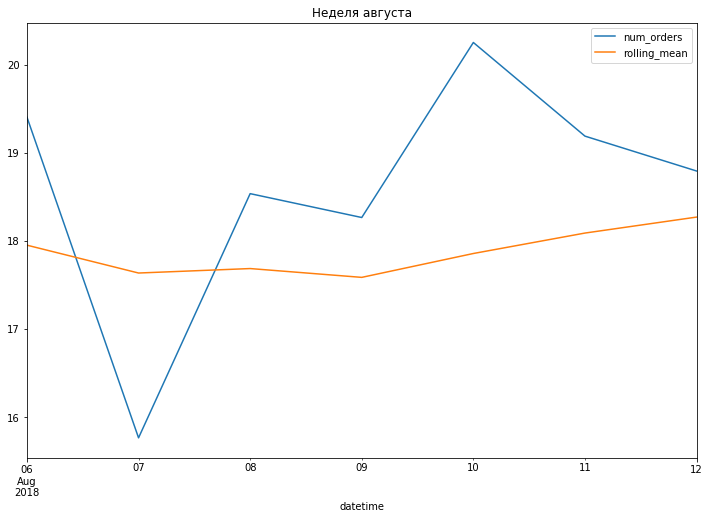

In [10]:
df_week = df_week.resample('1D').mean()

df_week['rolling_mean'] = df_week.rolling(10).mean()


df_week['2018-04-02' : '2018-04-08'].plot(figsize=(12, 8))
plt.title('Неделя апреля')
plt.show()
df_week['2018-08-06' : '2018-08-12'].plot(figsize=(12, 8))
plt.title('Неделя августа')

Взял две случайные недели разных месяцев, наблюдаем похожие ситуации. Меньше всего заказывают такси во вторник и к пятнице достигается максимальное количество заказов за неделю. Также высокий спрос в понедельник, могу предположить, что после выходных у людей сбивается режим, многие опаздывают и вызывают такси. Хотя боле убедительно звучит, что это ночные заказы людей в ночь с понедельника по воскресенье после 00:00, люди возращаются домой. Попробую проверить это.

Text(0.5, 1.0, 'Август: 5.08 - 6.08')

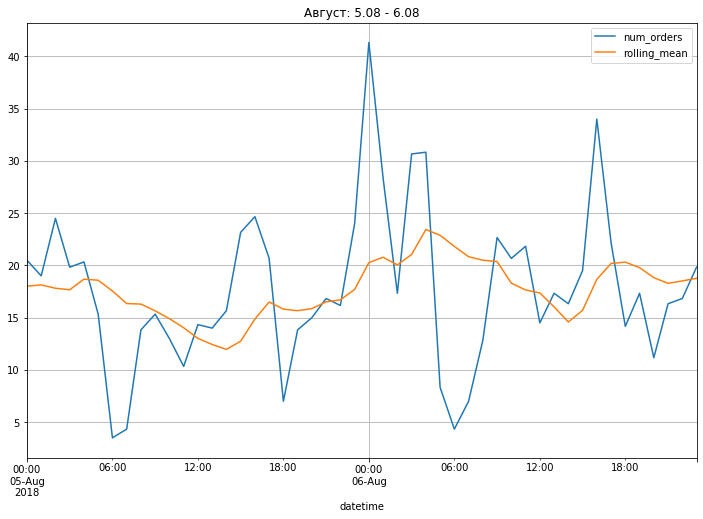

In [11]:
df_2 = data.resample('1H').mean()

df_2['rolling_mean'] = df_2.rolling(10).mean()

df_2['2018-08-05' : '2018-08-06'].plot(figsize=(12, 8), grid=True)
plt.title('Август: 5.08 - 6.08')

В целом мое второе предположение подтверждается, большое количество заказов приходится на ночь с воскресенья на понедельник

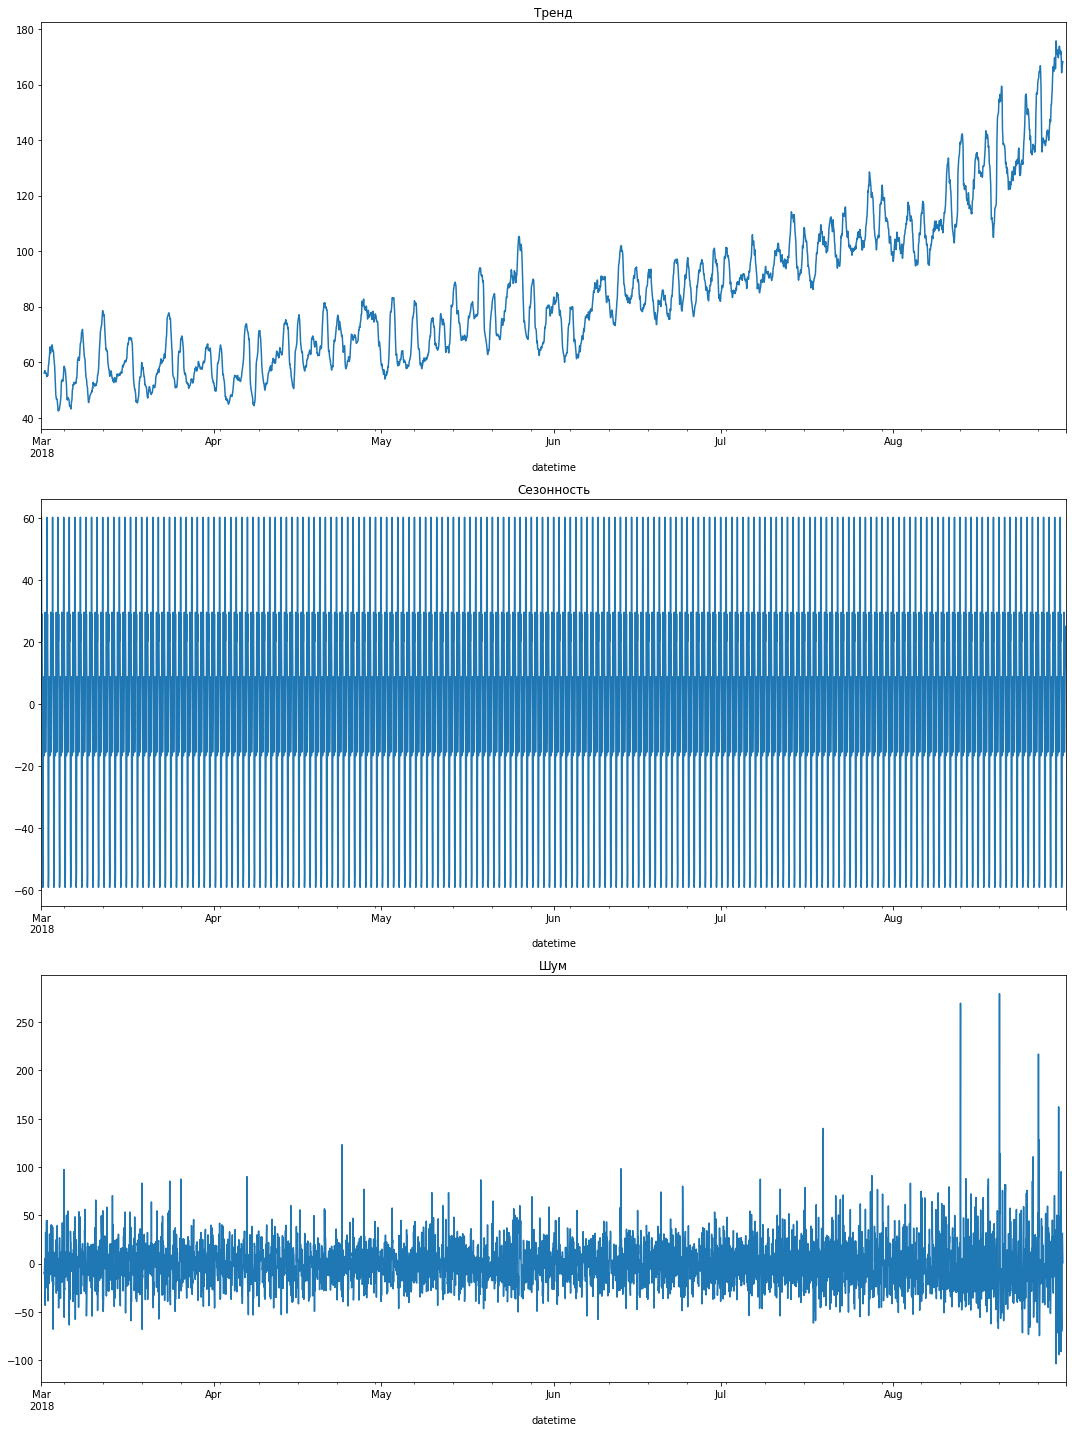

In [12]:
decomposed = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(15, 20))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)


decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)


decomposed.resid.plot(ax=plt.gca())
plt.title('Шум')
plt.tight_layout()

не очень хорошо видно информацию на этих графиках, поэтому попробую взять какой-то небольшой период


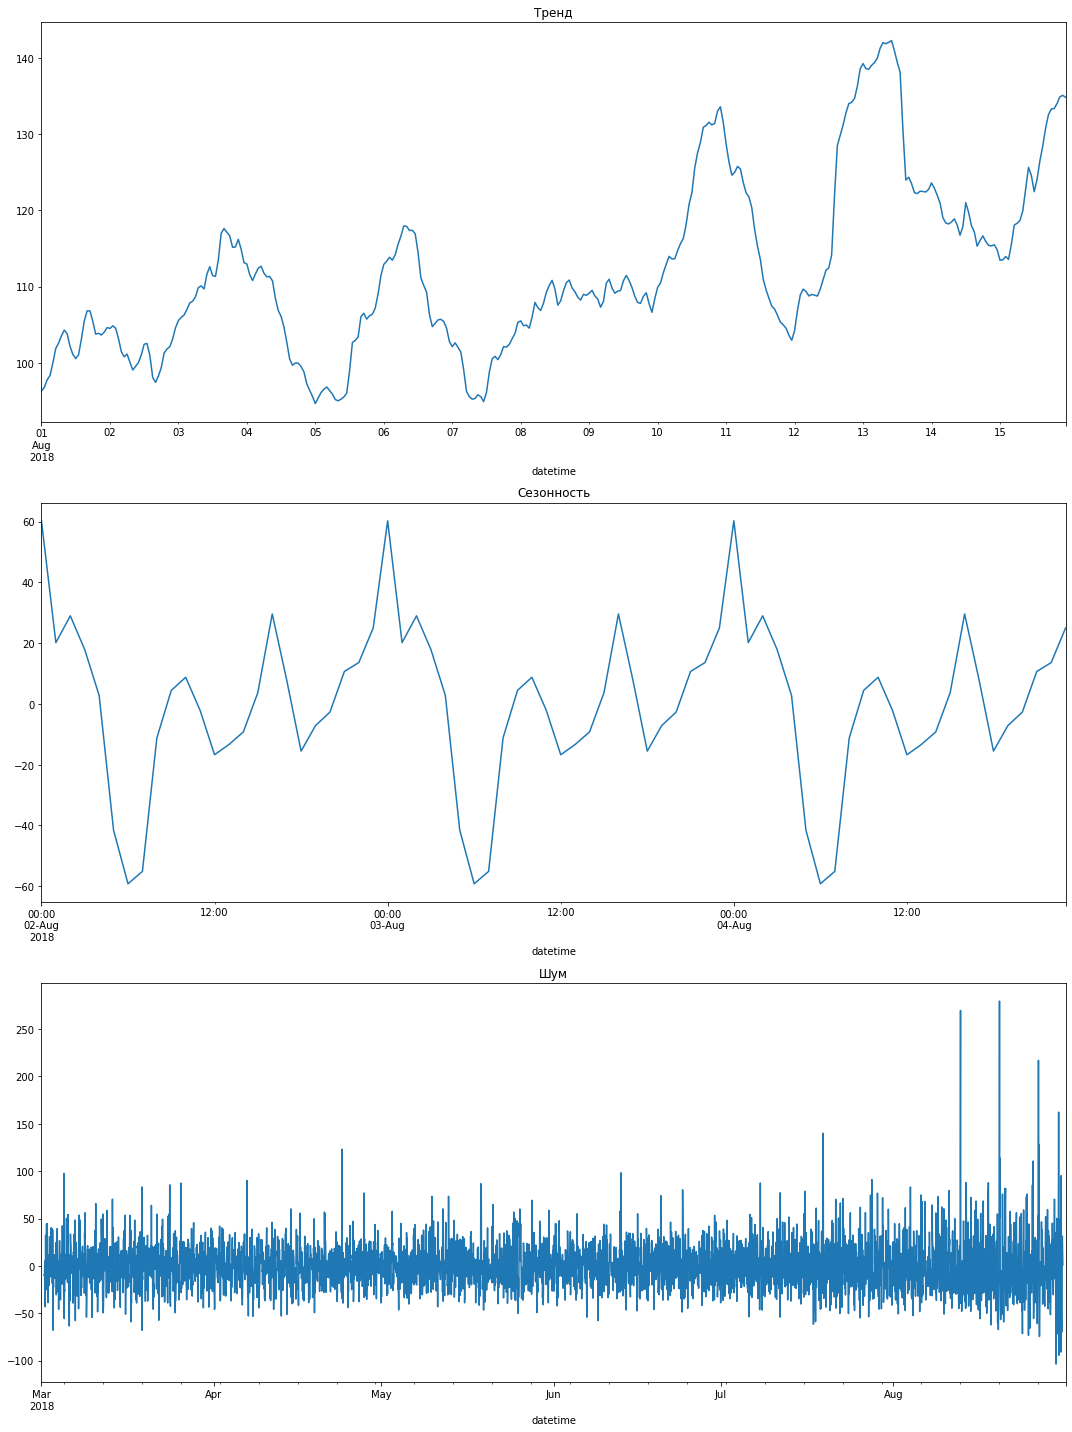

In [13]:
decomposed = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(15, 20))
plt.subplot(311)

decomposed.trend['2018-08-01' : '2018-08-15'].plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)


decomposed.seasonal['2018-08-02' : '2018-08-04'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)


decomposed.resid.plot(ax=plt.gca())
plt.title('Шум')
plt.tight_layout()

Я взял первые 15 дней августа, как последнего месяца из имеющихся данных. Теперь видно лучше. По сути все только подтверждает мои предыдущие выводы.

1. Тренд определяется днем недели, ростет к пятнице и падает к понедельнику-вторнику. Если смотреть глобальный тренд, то спрос на такси растет. Вероятно, если бы у нас было больше данных мы могли бы видеть, что спрос достигает максимального значения зимой(потому что холодно, возможно такси вызывают чаще) и становится меньше весной. Это только предположение, поскольку данных для проверки у нас нет, не будем это брать в расчет.

2. Сезонность определяется временем суток.

3. Шум не интерпритируется.

### Надо сделать ряд стационарным, чтобы можно было предсказывать

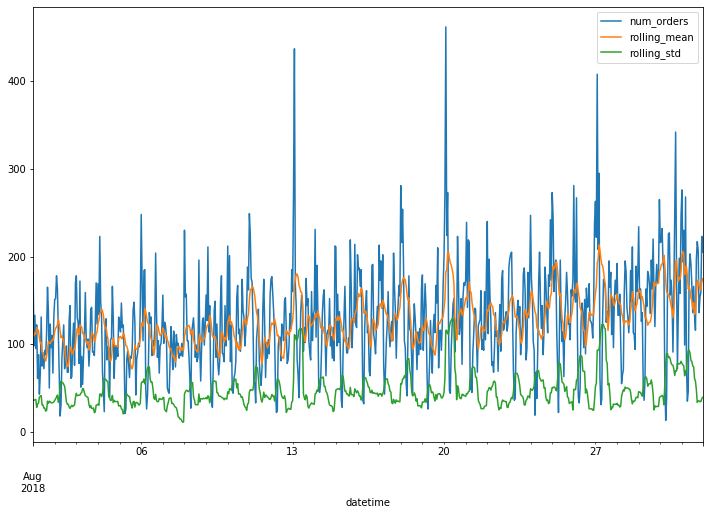

In [14]:
df['rolling_std'] = df['num_orders'].rolling(10).std()

df['2018-08-01' : '2018-08-31'].plot(figsize=(12, 8))

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    
    
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean() 

In [16]:
make_features(df, 1, 24)

In [17]:
df.head()

,num_orders,rolling_mean,rolling_std,day,dayofweek,hour,lag_1
datetime,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,1,3,0,NaN
2018-03-01 01:00:00,85,NaN,NaN,1,3,1,124.0
2018-03-01 02:00:00,71,NaN,NaN,1,3,2,85.0
2018-03-01 03:00:00,66,NaN,NaN,1,3,3,71.0
2018-03-01 04:00:00,43,NaN,NaN,1,3,4,66.0


In [18]:
df.isnull().sum()

num_orders       0
rolling_mean    24
rolling_std      9
day              0
dayofweek        0
hour             0
lag_1            1
dtype: int64

## Обучение

In [19]:
df = df.dropna()
train, test = train_test_split(df, test_size=0.1, shuffle = False)

print(train.shape)
print(test.shape)

(3952, 7)
(440, 7)


In [20]:
print(train.index)
print(test.index)

DatetimeIndex(['2018-03-02 00:00:00', '2018-03-02 01:00:00',
               '2018-03-02 02:00:00', '2018-03-02 03:00:00',
               '2018-03-02 04:00:00', '2018-03-02 05:00:00',
               '2018-03-02 06:00:00', '2018-03-02 07:00:00',
               '2018-03-02 08:00:00', '2018-03-02 09:00:00',
               ...
               '2018-08-13 06:00:00', '2018-08-13 07:00:00',
               '2018-08-13 08:00:00', '2018-08-13 09:00:00',
               '2018-08-13 10:00:00', '2018-08-13 11:00:00',
               '2018-08-13 12:00:00', '2018-08-13 13:00:00',
               '2018-08-13 14:00:00', '2018-08-13 15:00:00'],
              dtype='datetime64[ns]', name='datetime', length=3952, freq='H')
DatetimeIndex(['2018-08-13 16:00:00', '2018-08-13 17:00:00',
               '2018-08-13 18:00:00', '2018-08-13 19:00:00',
               '2018-08-13 20:00:00', '2018-08-13 21:00:00',
               '2018-08-13 22:00:00', '2018-08-13 23:00:00',
               '2018-08-14 00:00:00', '2018-08-1

In [21]:
print(train.isnull().sum())
print(test.isnull().sum())

num_orders      0
rolling_mean    0
rolling_std     0
day             0
dayofweek       0
hour            0
lag_1           0
dtype: int64
num_orders      0
rolling_mean    0
rolling_std     0
day             0
dayofweek       0
hour            0
lag_1           0
dtype: int64


In [22]:
features_train = train.drop('num_orders', axis = 1)
features_test = test.drop('num_orders', axis = 1)
target_train = train['num_orders']
target_test = test['num_orders']

In [23]:
print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(3952, 6) (440, 6) (3952,) (440,)


In [24]:
primer = pd.DataFrame({'n' : ['1_splits', '2_splits', '3_splits', '4_splits'],
                       'fold_1' : ['train', 'train', 'train', 'train'],
                       'fold_2' : ['test', 'train', 'train', 'train'],
                       'fold_3' : ['NaN', 'test', 'train', 'train'],
                       'fold_4' : ['NaN', 'NaN', 'test', 'train'],
                       'fold_5' : ['NaN', 'NaN', 'NaN', 'test']})

primer

,n,fold_1,fold_2,fold_3,fold_4,fold_5
0,1_splits,train,test,NaN,NaN,NaN
1,2_splits,train,train,test,NaN,NaN
2,3_splits,train,train,train,test,NaN
3,4_splits,train,train,train,train,test


# CatBoostRegressor

Закомментил поиск параметров, чтобы не грузилось каждый раз, когда запускаешь run all. В моделях стоят параметры подобранные через gridsearch

In [25]:
%%time

cat = CatBoostRegressor(loss_function = 'RMSE', iterations = 1000, depth = 6, learning_rate = 0.03, verbose = False)
cat.fit(features_train, target_train, plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 18.5 s, sys: 4.12 s, total: 22.6 s
Wall time: 24.8 s


In [26]:
%%time

cat_pred = cat.predict(features_test)

CPU times: user 3.63 ms, sys: 7.13 ms, total: 10.8 ms
Wall time: 3.39 ms


In [27]:
rmse_cat = mean_squared_error(target_test, cat_pred)**0.5
print('RMSE CatBoost:', rmse_cat)

RMSE CatBoost: 42.69351799103835


# LineRegression

In [28]:
%%time

line_model = LinearRegression()
line_model.fit(features_train, target_train)

CPU times: user 658 µs, sys: 3.8 ms, total: 4.46 ms
Wall time: 3.39 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [29]:
%%time

line_pred = line_model.predict(features_test)

print('RMSE LineRegression:', mean_squared_error(target_test, line_pred)**0.5)

RMSE LineRegression: 51.222503946225395
CPU times: user 1.15 ms, sys: 3.87 ms, total: 5.02 ms
Wall time: 2.33 ms


## Тестирование

In [30]:
cat_pred = cat.predict(features_test)

rmse_cat = mean_squared_error(target_test, cat_pred)**0.5
print('RMSE CatBoost:', rmse_cat)

RMSE CatBoost: 42.69351799103835


In [32]:
line_pred = line_model.predict(features_test)
rmse_line = mean_squared_error(target_test, line_pred)**0.5

print('RMSE LineRegression:', rmse_line)

RMSE LineRegression: 51.222503946225395


In [33]:
target_test = pd.DataFrame(target_test)
target_test

,num_orders
datetime,
2018-08-13 16:00:00,144
2018-08-13 17:00:00,152
2018-08-13 18:00:00,104
2018-08-13 19:00:00,91
2018-08-13 20:00:00,82
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [35]:
target_test['cat_pred'] = cat_pred

target_test['line_pred'] = line_pred

target_test

,num_orders,cat_pred,line_pred
datetime,,,
2018-08-13 16:00:00,144,163.240925,152.321056
2018-08-13 17:00:00,152,123.694219,138.941921
2018-08-13 18:00:00,104,89.079731,143.619949
2018-08-13 19:00:00,91,99.686806,122.637643
2018-08-13 20:00:00,82,103.879779,117.141937
...,...,...,...
2018-08-31 19:00:00,136,103.035524,180.369579
2018-08-31 20:00:00,154,134.648100,149.982104
2018-08-31 21:00:00,159,137.473199,158.572553


Text(0.5, 1.0, 'Предсказания CatBoost')

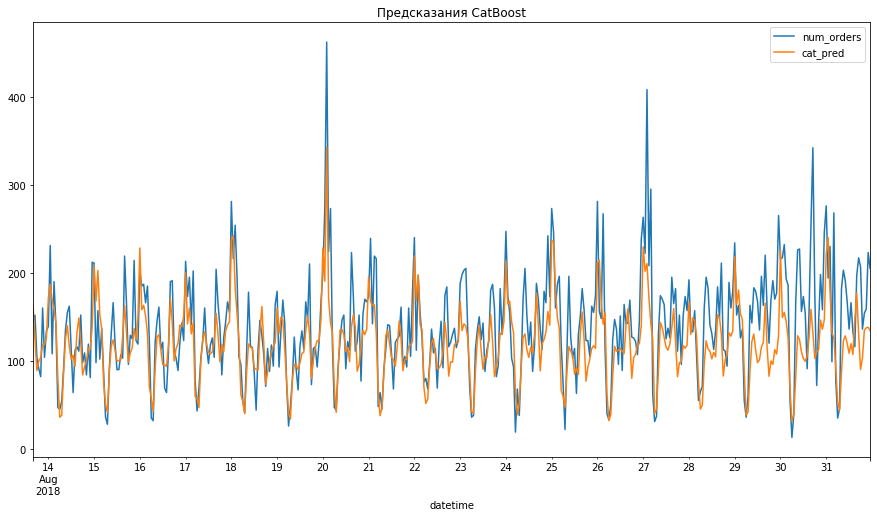

In [36]:
target_test[['num_orders', 'cat_pred']].plot(figsize=(15, 8))
plt.title('Предсказания CatBoost')

Text(0.5, 1.0, 'Предсказания LinearRegression')

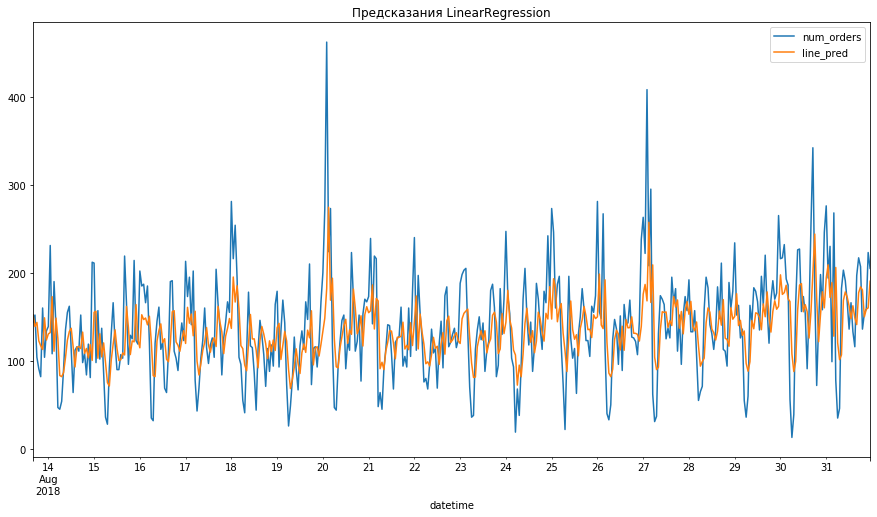

In [38]:
target_test[['num_orders', 'line_pred']].plot(figsize=(15, 8))
plt.title('Предсказания LinearRegression')

In [44]:
final = pd.DataFrame(
    {'model' : ['catboost', 'linear'],
     'rmse' : [rmse_cat, rmse_line],
     'time_fit' : ['0.0248', '0.0033'],
     'time_pred' : ['0.0033', '0.0023']})

final.set_index('model', inplace = True)
final

,rmse,time_fit,time_pred
model,,,
catboost,42.693518,0.0248,0.0033
linear,51.222504,0.0033,0.0023


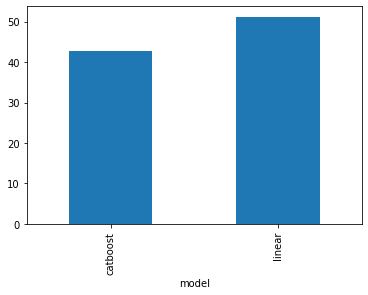

In [45]:
final['rmse'].plot.bar()

Самые точные предсказания дает модель CatBoost

In [46]:
final[['time_pred', 'time_fit']] = final[['time_pred', 'time_fit']].astype('float')

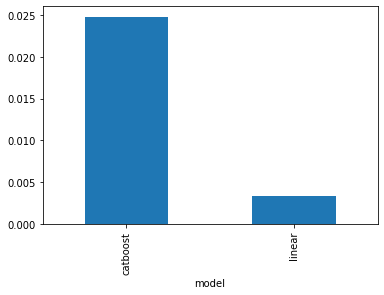

In [47]:
final['time_fit'].plot.bar()

Быстрее всех обучается линейная регрессия, ожидаемо, ведь там нет бустинга

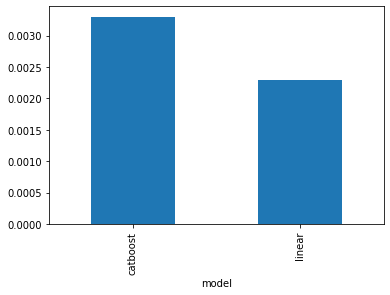

In [48]:
final['time_pred'].plot.bar()

Самая высокая скорость предсказаний у CatBoost

# Вывод

Лучшей моделью по точности и скокрости предсказаний оказался CatBoost. Модель предсказывает неплохо движение графика, но слабо определяет пиковые значения вверху и внизу. Предсказания очень быстрые у catboost 6,3 мс, отлично подойдет для онлайн сервиса, которым такси и является) На всех моделях достигнуто качество < 48